# Filter Visualisation tutorial

In order to visualize filters you need a trained architecture and at least one subject to generate filters for.

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mne.viz import plot_topomap
from meegnet.network import Model
from meegnet.dataloaders import Dataset

/home/arthur/.pyvenv/meegnet/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Constants

In [2]:
# We set up our data to be 3 channel types (MAG GRAD GRAD),
# 102 sensor locations (Elekta Neuromag Vector View 306 channel MEG),
# and 400 time samples for 800ms of signal sampled as 500Hz.
sensors = ["MAG", "PLANNAR1", "PLANNAR2"]
n_channels = len(sensors)
input_size = (n_channels, 102, 400)

n_outputs = 2 # using auditory vs visual stimulus classification -> 2 classes

# Setting up paths
save_path = "/home/arthur/data/"

clf_type = "eventclf"

### Loading the model

In [3]:
# setting up a seed for reproducibility (will be used for numpy, pandas, torch, and the meegnet library)
seed = 41 

# net option can be "meegnet", "eegnet" etc, see documentation
net_option = "meegnet" 

# name of the model
name = f"eventclf_{net_option}_{seed}_{n_channels}"

my_model = Model(name, net_option, input_size, n_outputs, save_path=save_path)
my_model.from_pretrained()
# model_path = os.path.join(save_path, "net_42_fold1_MAG.pt")
# my_model.load(model_path)

model_weights = my_model.get_feature_weights()

### Creating topomaps for the first CNN layer

The first layer of the meegnet CNN is a spatial de-mixing layer and is therefore a collection of vectors attaching importance weights to each of the sensor location. We can project those on a MNE-python topomap to visualise weight and sensor importance.

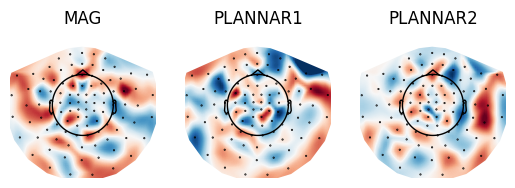

In [4]:
def generate_layer_topomap(weights, sensors, info, save=False):
    fig, axs = plt.subplots(1, len(sensors))
    filter_mean = np.mean(weights, axis=0)
    
    for i, sens in enumerate(sensors):
        ax = axs[i] if n_channels > 1 else axs
        im, _ = plot_topomap(
            filter_mean[i].ravel(),
            info,
            show=False,
            axes=ax,
            contours=False,
        )
        ax.axis("off")
        ax.title.set_text(sens)
        
    if save:
        plt.savefig(os.path.join(viz_path, name, "filters.png"))
    plt.show()
    plt.close()

info = np.load("../camcan_sensor_locations.npy", allow_pickle=True).tolist()
weights = model_weights[0]

generate_layer_topomap(weights, sensors, info)

### Loading data

Next we load data based on the data framework established in the prepare data tutorial. We choose to only use one subject and one sample per label of the subject as an example.

In [5]:
csv_file = os.path.join(save_path, f"participants_info.csv")
dataframe = (
    pd.read_csv(csv_file, index_col=0)
    .sample(frac=1, random_state=seed)
    .reset_index(drop=True)
)
subj_list = dataframe["sub"]
np.random.seed(seed)
sub = np.random.choice(subj_list)

# Incrementing and changing subject in case there is an error with loading subject data
data = []
while data == []:
    dataset = Dataset(
        sfreq=500, # sampling frequency of 500Hz
        sensortype='ALL', # we use MAG GRAD GRAD here
        lso=True,
        random_state=seed,
    )
    dataset.load(save_path, one_sub=sub)
    data = dataset.data

def pick_random():
    input_tensor = data.to(torch.float).cuda()
    random_index = np.random.choice(np.arange(len(input_tensor)))
    lab = dataset.labels[random_index]
    random_sample = input_tensor[random_index][np.newaxis, :]
    return random_sample.cuda(), int(lab)

random_samples, labels = [None, None], [None, None]
random_samples[0], labels[0] = pick_random()
while True:
    random_samples[1], labels[1] = pick_random()
    if labels[0] != labels[1]:
        break
        
print(f"subject: {sub}")

subject: CC220115


### Compute outputs for loaded data

We compute the outputs of each layer for the loaded data:

In [6]:
outputs = []
for rs, lab in zip(random_samples, labels):
    results = [my_model.net.feature_extraction[0](rs)]
    for layer in my_model.net.feature_extraction[1:-2]:
        results.append(layer(results[-1]))
    outputs.append((results[2:], lab)) # We ignore first two layers as they are "spatial" layers

### Generate figure

Finally we generate the figure

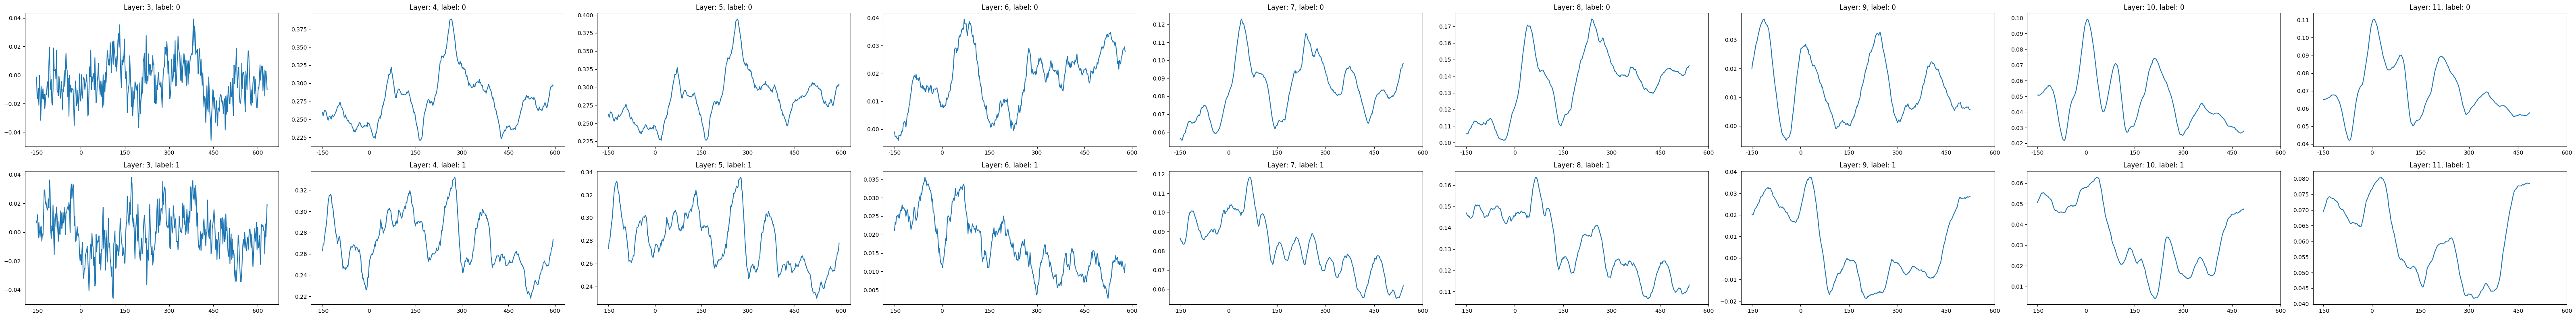

In [7]:
nrows, ncols = len(labels), len(outputs[0][0])
dx, dy = 4, 1
figsize = plt.figaspect(float(dy * nrows) / float(dx * ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=4*figsize)

for results, lab in outputs:
    for layer_idx, out in enumerate(results):
        layer_viz = out[0].detach().cpu()
        if len(layer_viz.shape) <= 1:
            continue
        filter_mean = None
        for filt in layer_viz:
            if filter_mean is None:
                filter_mean = filt/len(layer_viz)
            else:
                filter_mean += filt/len(layer_viz)
        axes[lab, layer_idx].plot(np.arange(len(filter_mean[0])), filter_mean[0])
        axes[lab, layer_idx].set_xticks((0, 75, 150, 225, 300, 375))
        axes[lab, layer_idx].set_xticklabels((-150, 0, 150, 300, 450, 600))
        axes[lab, layer_idx].title.set_text(f"Layer: {layer_idx+3}, label: {lab}") # correcting for ignored layers

plt.tight_layout()
# fig.savefig("figure")
plt.show()
plt.close()